## IMDB data analysis with scikit-learn & custom algorithms
### Naive Bayes Classifier

We define the hyperparameters required for the data we will use below.

In [1]:
m = 3000   # Number of words in the vocabulary
n = 50    # N most frequent words to skip
k = 80      # K least frequent words to skip

infogain = False 
g = 800 

We take the data from the IMDB database, ignoring the most n frequently used words  and the k least frequently used words .

(These are the hyperparameters we defined above.)

In [2]:
import tensorflow as tf
import numpy as np
from math import log 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Creation of binary vectors
We modify the data we got so that they become binary vectors. These vectors consist of 0 and 1, with 1 meaning that the word exists in the text, while 0 means it does not.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)

Vocabulary size: 2813


X is an array of vectors (reviews), with each vector representing words.
Y is a vector of labels (0 or 1) where 0 is a negative review and 1 a positive one.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \,
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

### Information Gain
It's code from the labs. Returns the g words with the highest information gain from the dataset.

In [4]:
from math import log 

if infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0 # Αρχικοποίηση της εντροπίας του χαρακτηριστικού Hc_feature.
    for feat in feature_values:
      
      # Υπολογισμός του P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          # Υπολογισμός του P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # Υπολογισμός του - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    # Υπολογισμός του information gain.
    ig = Hc - Hc_feature
    return ig

  # Επιλογή των g πιο σημαντικών χαρακτηριστικών.
  ig = [(i, IG(y_train, x_train_binary[:, i])) for i in range(len(x_train_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]
  # Προσαρμογή των δεδομένων εκπαίδευσης και ελέγχου.
  x_train_binary = x_train_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_binary[:, [i[0] for i in ig]]

### Implementation of Bernoulli Naive Bayes Classifier
Class that implements the Bernoulli Naive Bayes Classifier. The class has two methods fit and predict. The fit method trains the algorithm using a given matrix of x vectors. The predict method takes as input an array of vectors and returns a vector of labels.

We also use a Laplace estimator to smooth probabilities and avoid null estimates.

In [5]:
class BernoulliNaiveBayes:
  
  def __init__(self):
    pass 

  def fit(self, x, y):
    all_positive = np.sum(y)
    all_texts = len(y)
    all_negative = all_texts - all_positive

    # Υπολογισμός της (log) πιθανότητας για κάθε κλάση
    self.positive = np.log(all_positive / all_texts)
    self.negative = np.log(all_negative / all_texts)
    
    # Υπολογισμός (log) πιθανότητας για κάθε σύνολο χαρακτηριστικών δεδομένα κάθε κλάσης (y = 1 ή y = 0)
    self.positive_1 = np.log((np.sum(x[y == 1], axis=0) + 1) / (all_positive + 2))
    self.negative_1 = np.log((np.sum(x[y == 0], axis=0) + 1) / (all_negative + 2))
    self.positive_0 = np.log(1.0 - (np.sum(x[y == 1], axis=0) + 1) / (all_positive + 2))
    self.negative_0 = np.log(1.0 - (np.sum(x[y == 0], axis=0) + 1) / (all_negative + 2))
    
    
  def predict(self, x):

    x_reverse = np.where((x==0)|(x==1), x^1, x)
    # Υπολογισμός των (log) πιθανοτήτων για κάθε κλάση
    positive = x_reverse.dot(self.positive_0) + x.dot(self.positive_1) + self.positive
    negative = x_reverse.dot(self.negative_0) + x.dot(self.negative_1) + self.negative
    # Καθορισμός της πρόβλεψης βάσει των (log) πιθανοτήτων
    return np.array([1 if positive[i] > negative[i] else 0 for i in range(len(x))])

In [6]:
from visualizations import *

## Results of the Bernoulli Naive Bayes Classifier

The Naive Bayes Classifier is tested on the test data and the results are shown in the table below. A comparison is also made between the prediction results of the training data and the test data.

In [7]:
data = classification_data(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)

print(classification_report(y_test, data['test_predictions']))
data_table = classification_table(data, x_train_binary)
ipd.display(data_table)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.87,0.84,0.88,0.85,0.87,0.83,0.88,0.84
10000,0.87,0.85,0.86,0.85,0.87,0.85,0.87,0.85
15000,0.86,0.85,0.86,0.85,0.87,0.84,0.86,0.85
20000,0.86,0.85,0.86,0.85,0.86,0.84,0.86,0.85
25000,0.86,0.85,0.85,0.85,0.87,0.85,0.86,0.85


### Bernoulli Naive Bayes Learning Curve

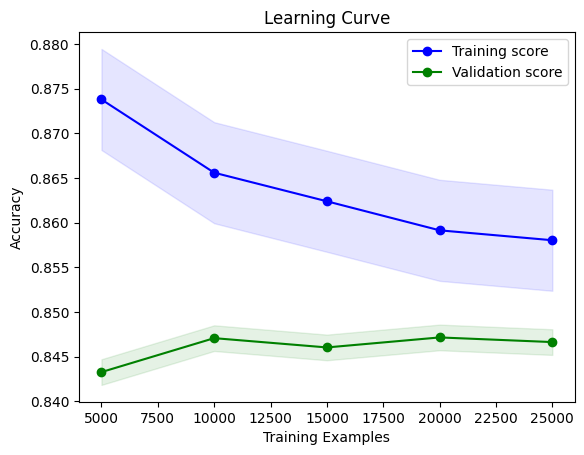

In [8]:
plot_learning_curve(data)

### Precision,accuracy, recall and F1 curves

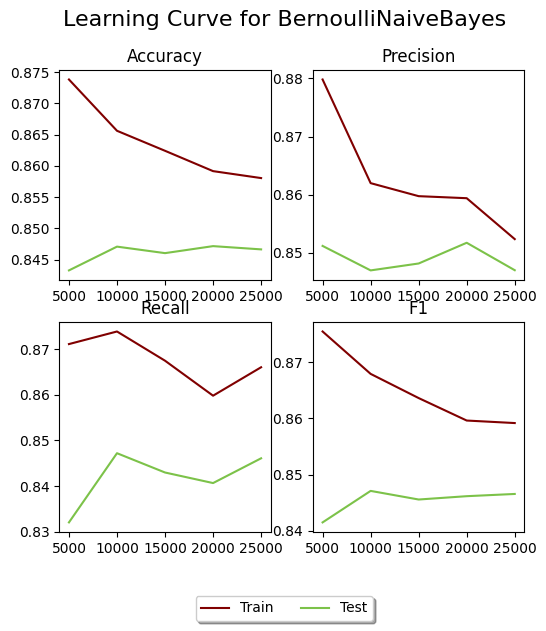

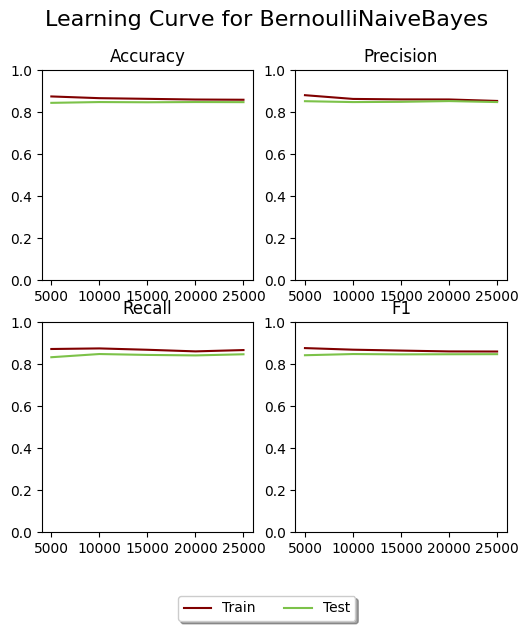

In [9]:
classification_plots(data)
r = classification_plots(data, True)

## Comparison of Bernoulli Naive Bayes and SKLearn's Bernoulli Naive Bayes

Bernoulli Naive Bayes is tested against SKLearn library's Bernoulli Naive Bayes. The results are shown in the table below and as expected they are similar. (Below is the difference between the results given by each algorithm)

In [10]:
from sklearn.naive_bayes import BernoulliNB

bayes_data = classification_data(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)
bayes_data['estimator'] = "SKLearn's BernoulliNB"
bayes_table = classification_table(bayes_data, x_train_binary)
difference_table = abs(bayes_table - data_table)
difference_table = difference_table.style.set_caption('Πίνακας Διαφοράς για τον {estimator} και τον {estimator_2}'.format(estimator=data['estimator'], estimator_2=bayes_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


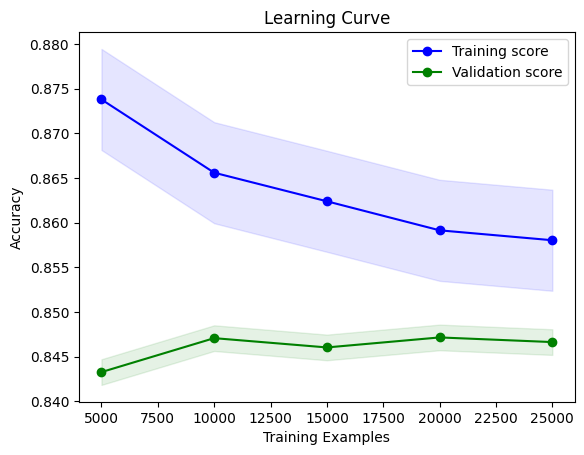

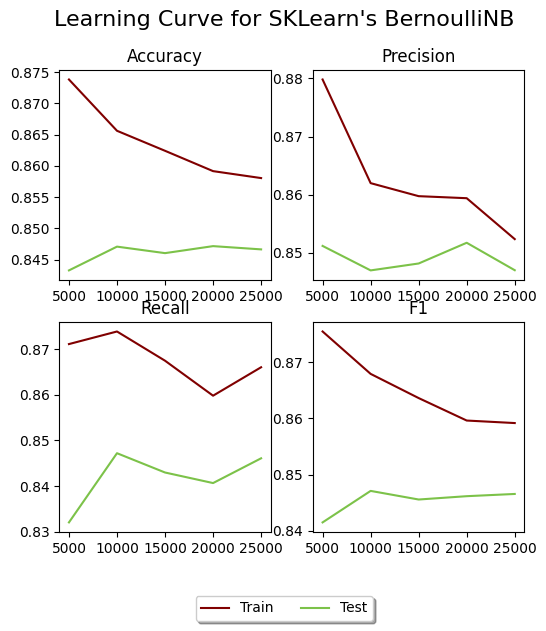

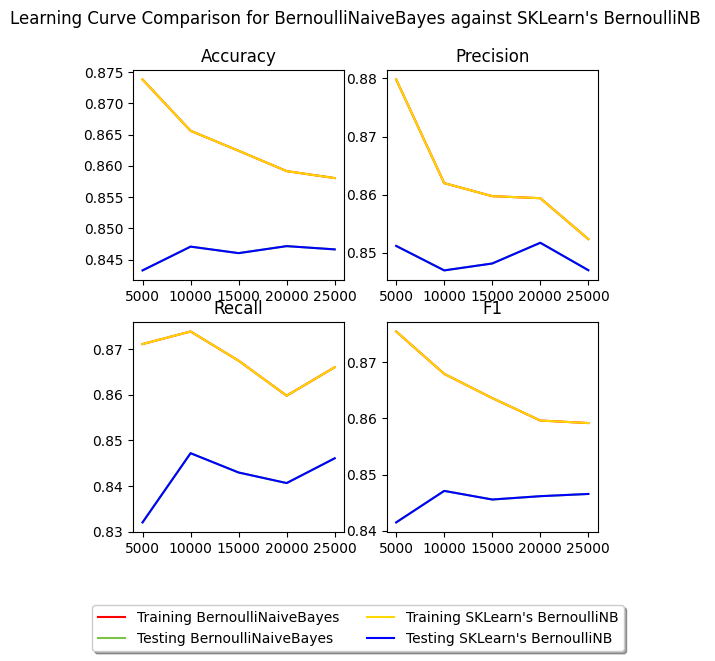

In [13]:
plot_learning_curve(bayes_data)
classification_plots(bayes_data)
r = classification_plots_compare(data, bayes_data, False)

### Comparison of Bernoulli Naive Bayes and SKLearn's Logistic Regression

Bernoulli Naive Bayes is tested against the SKLearn library's Logistic Regression. The results are shown below in the table and we notice that the two algorithms are very close to each other. (Below is the difference between the results given by each algorithm)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.130000,0.000000,0.120000,0.020000,0.130000,0.010000,0.120000,0.000000
10000,0.100000,0.010000,0.110000,0.010000,0.100000,0.010000,0.100000,0.010000
15000,0.080000,0.000000,0.080000,0.000000,0.080000,0.010000,0.080000,0.000000
20000,0.070000,0.010000,0.070000,0.010000,0.080000,0.020000,0.070000,0.010000
25000,0.060000,0.010000,0.070000,0.010000,0.060000,0.010000,0.060000,0.010000


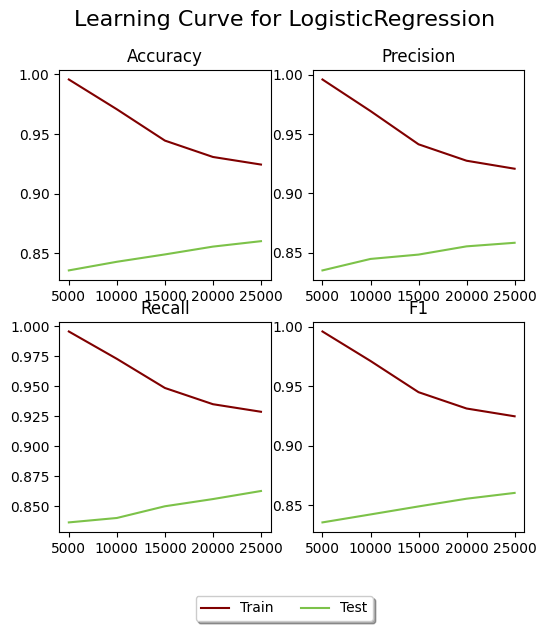

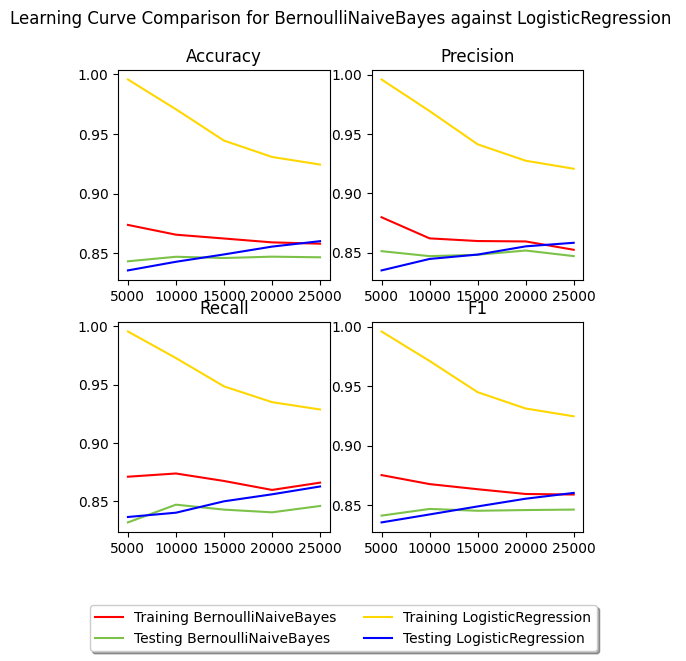

In [12]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(x_train_binary, y_train)
print(classification_report(y_test, log.predict(x_test_binary), zero_division=1))

log_data = classification_data(LogisticRegression(), x_train_binary, y_train, x_test_binary, y_test, 5)
log_data['estimator'] = 'LogisticRegression'
log_table = classification_table(log_data, x_train_binary)
difference_table_log = abs(log_table - data_table)
difference_table_log = difference_table_log.style.set_caption('Πίνακας Διαφοράς για τον {estimator} και τον {estimator_2}'.format(estimator=data['estimator'], estimator_2=log_data['estimator']))
ipd.display(difference_table_log)

classification_plots(log_data)
r = classification_plots_compare(data, log_data)


### Select Hyperparameters
We use the following code to decide which hyperparameters are best. In 3 arrays M, K, N, we have various values ​​with

M: number of vocabulary words

N: number of most frequent words to skip

K: number of rarest words to skip

We use the accuracy of the classifier on the development data to decide which combination of m, n, k is the best.

In [35]:
from sklearn.model_selection import train_test_split

N = [50, 100, 200, 300]
K = [0, 20, 50, 80]
M = [500, 2000, 2500, 3000]

binary_vectorizer = CountVectorizer(binary=True)
minK = 0
minN = 0
minM = 0
maxAccuracy = -float('inf')

for m in M:
    for n in N:
        for k in K:
            (x_trainn, y_trainn), (x_testt, y_testt) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
            x_trainn, x_dev, y_trainn, y_dev = train_test_split(x_trainn, y_trainn, test_size=0.2)
            word_index = tf.keras.datasets.imdb.get_word_index()

            index2word = dict((i + 3, word) for (word, i) in word_index.items())
            index2word[0] = '[pad]'
            index2word[1] = '[bos]'
            index2word[2] = '[oov]'

            x_trainn = np.array([' '.join([index2word[idx] for idx in text]) for text in x_trainn])
            x_dev = np.array([' '.join([index2word[idx] for idx in text]) for text in x_dev])

            x_trainn_binary = binary_vectorizer.fit_transform(x_trainn)
            x_val_binary = binary_vectorizer.transform(x_dev)

            x_trainn_binary = np.array(x_trainn_binary.toarray())
            x_val_binary = np.array(x_val_binary.toarray())
            
            bnb = BernoulliNaiveBayes()
            bnb. fit(x_trainn_binary, y_trainn)
            predicted_values = bnb.predict(x_val_binary)
            print("For M={}, N={} and K={}:".format(m, n, k))
            acc = accuracy_score(y_dev, predicted_values)
            print('Accuracy:', acc)
            if acc > maxAccuracy:
                maxAccuracy = acc
                minN = n
                minK = k
                minM = m

print("\nBest model parameters are:\n\tN: {}\n\tK:{} \n\tM: {}".format(minN, minK, minM))



For M=500, N=50 and K=0:
Accuracy: 0.805
For M=500, N=50 and K=20:
Accuracy: 0.7916
For M=500, N=50 and K=50:
Accuracy: 0.791
For M=500, N=50 and K=80:
Accuracy: 0.7916
For M=500, N=100 and K=0:
Accuracy: 0.7926
For M=500, N=100 and K=20:
Accuracy: 0.7916
For M=500, N=100 and K=50:
Accuracy: 0.7818
For M=500, N=100 and K=80:
Accuracy: 0.7894
For M=500, N=200 and K=0:
Accuracy: 0.781
For M=500, N=200 and K=20:
Accuracy: 0.785
For M=500, N=200 and K=50:
Accuracy: 0.7702
For M=500, N=200 and K=80:
Accuracy: 0.7648
For M=500, N=300 and K=0:
Accuracy: 0.7586
For M=500, N=300 and K=20:
Accuracy: 0.744
For M=500, N=300 and K=50:
Accuracy: 0.7344
For M=500, N=300 and K=80:
Accuracy: 0.7092
For M=2000, N=50 and K=0:
Accuracy: 0.85
For M=2000, N=50 and K=20:
Accuracy: 0.8458
For M=2000, N=50 and K=50:
Accuracy: 0.844
For M=2000, N=50 and K=80:
Accuracy: 0.8336
For M=2000, N=100 and K=0:
Accuracy: 0.8356
For M=2000, N=100 and K=20:
Accuracy: 0.8366
For M=2000, N=100 and K=50:
Accuracy: 0.8398
For